In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
p = sns.color_palette()


In [ ]:
sub_4 = pd.read_csv('Sub-LGBM-4.txt', sep='\t', 
                             header=None, 
                             names=['user_id', 'photo_id', 'click_probability'])

In [9]:
sub_5 = pd.read_csv('Sub-LGBM-5.txt', sep='\t', 
                             header=None, 
                             names=['user_id', 'photo_id', 'click_probability'])

In [10]:
sub_6 = pd.read_csv('Sub-LGBM-6.txt', sep='\t', 
                             header=None, 
                             names=['user_id', 'photo_id', 'click_probability'])

In [5]:
def plot_data_cut(df, col, n_bins=20):
    quartiles = pd.cut(df[col], n_bins)
    grouped = df.groupby(quartiles)
    
    plt.figure(figsize=(30,15)) 
    plt.xlabel(col)
    plt.ylabel('counts in ' + col)
    nums_of_col = grouped.size()
    nums_of_col.plot.bar()

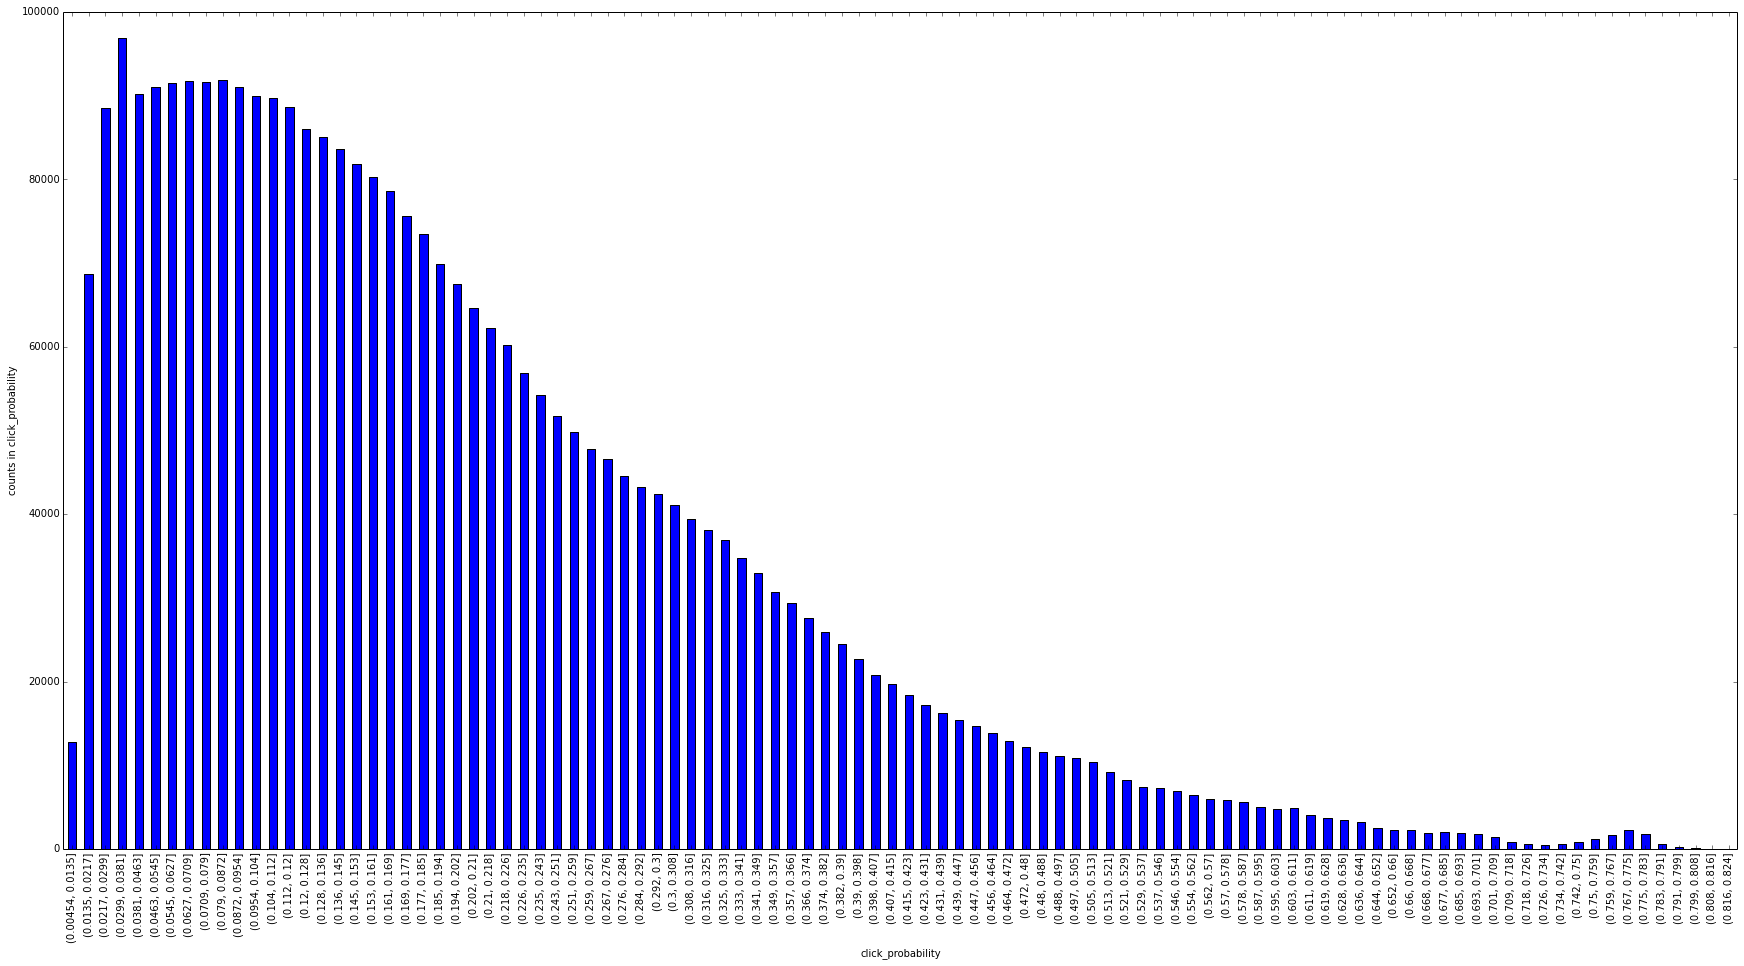

In [8]:
plot_data_cut(sub_4, 'click_probability', 100)

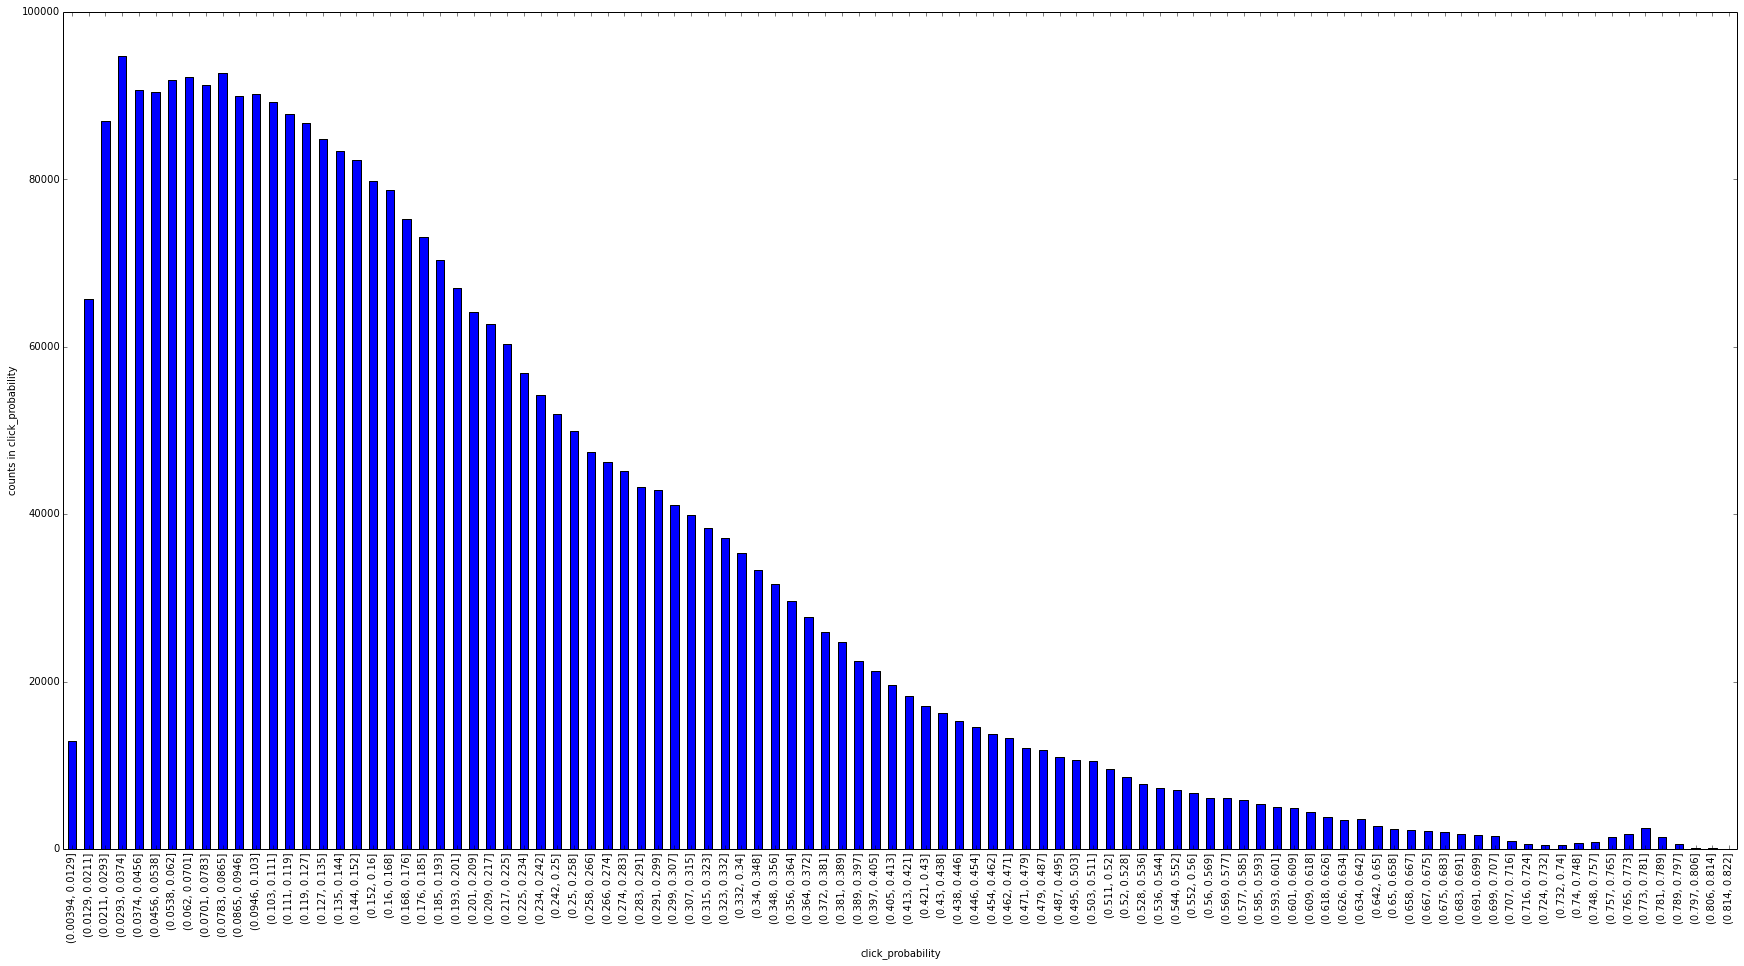

In [11]:
plot_data_cut(sub_5, 'click_probability', 100)

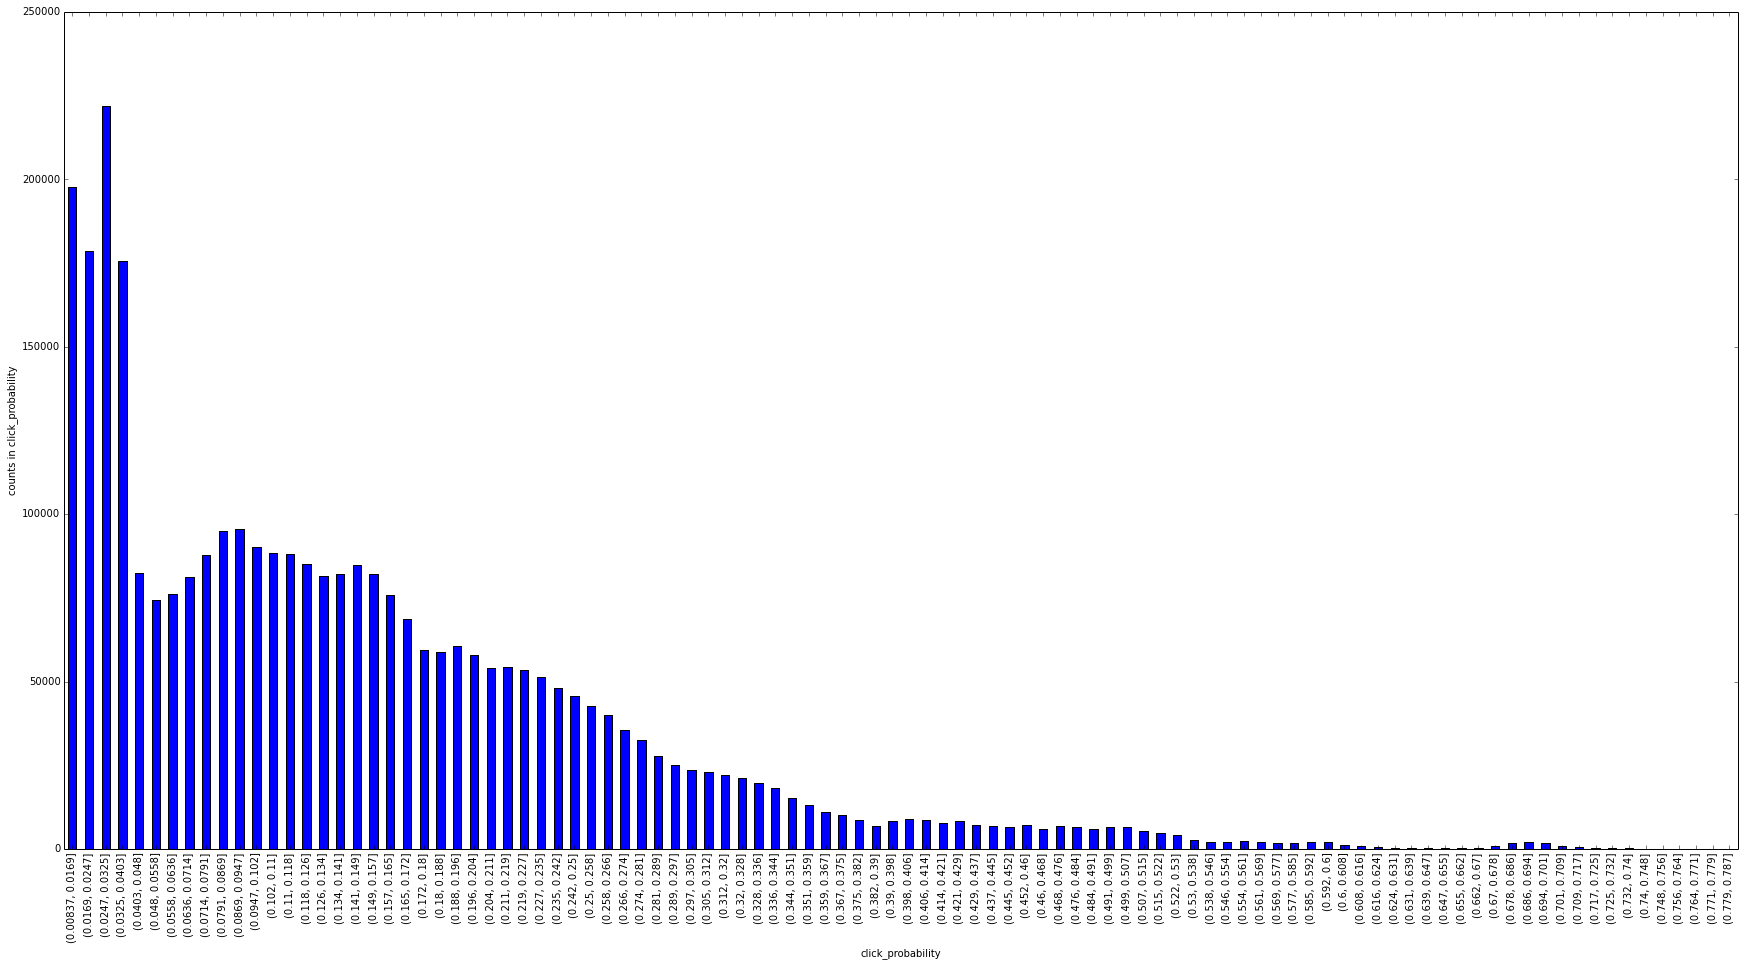

In [12]:
plot_data_cut(sub_6, 'click_probability', 100)

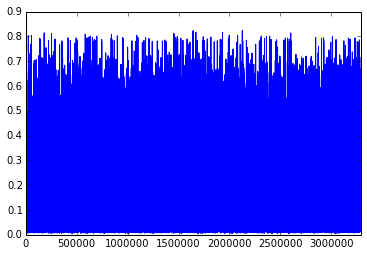

In [15]:
sub_4.click_probability.plot()

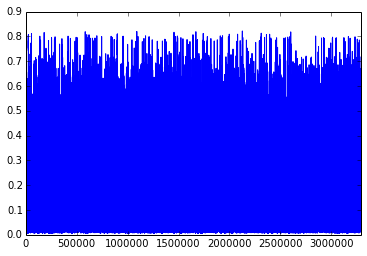

In [13]:
sub_5.click_probability.plot()

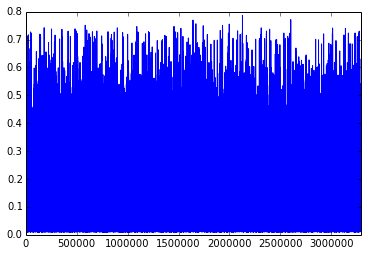

In [14]:
sub_6.click_probability.plot()

In [3]:
cols = ['user_id', 'photo_id', 'browse_num', 'click_num', 'like_num', 'follow_num', 'playing_sum', 'duration_sum', 'click_ratio', 'like_ratio', 'follow_ratio', 'playing_ratio', 'browse_time_diff', 'click_freq', 'browse_freq', 'playing_freq', 'man_favor', 'woman_favor', 'man_cv_favor', 'woman_cv_favor', 'man_age_favor', 'woman_age_favor', 'man_yen_value_favor', 'woman_yen_value_favor', 'face_click_favor', 'non_face_click_favor', 'cover_length_favor', 'exposure_num', 'have_face_cate', 'clicked_ratio', 'face_num', 'man_num', 'woman_num', 'man_scale', 'woman_scale', 'human_scale', 'man_avg_age', 'woman_avg_age', 'human_avg_age', 'man_avg_attr', 'woman_avg_attr', 'human_avg_attr', 'cover_length', 'time', 'duration_time', 'click']

In [19]:
ensemble_train = pd.read_csv('../data/features/ensemble_feature_train.csv',
                            sep='\t')

In [20]:
ensemble_train.head()

,user_id,photo_id,browse_num,click_num,like_num,follow_num,playing_sum,duration_sum,click_ratio,like_ratio,...,man_avg_age,woman_avg_age,human_avg_age,man_avg_attr,woman_avg_attr,human_avg_attr,cover_length,time,duration_time,click
0,1637,6484142,1736,365,4,0,4124,27726,0.210253,0.002304,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,2,761036604603,11,0
1,1637,4647664,1736,365,4,0,4124,27726,0.210253,0.002304,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,8,761035501863,11,0
2,1637,4994626,1736,365,4,0,4124,27726,0.210253,0.002304,...,26.333333,0.0,26.333333,48.333333,0.0,48.333333,3,761036933553,10,1
3,1637,4416881,1736,365,4,0,4124,27726,0.210253,0.002304,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1,761119247892,9,0
4,1637,2597756,1736,365,4,0,4124,27726,0.210253,0.002304,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1,761119421332,11,0


In [21]:
ensemble_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20854344 entries, 0 to 20854343
Data columns (total 44 columns):
user_id                  int64
photo_id                 int64
browse_num               int64
click_num                int64
like_num                 int64
follow_num               int64
playing_sum              int64
duration_sum             int64
click_ratio              float64
like_ratio               float64
follow_ratio             float64
playing_ratio            float64
browse_time_diff         int64
click_freq               float64
browse_freq              float64
playing_freq             float64
face_favor               float64
man_favor                float64
woman_favor              float64
man_cv_favor             float64
woman_cv_favor           float64
man_age_favor            float64
woman_age_favor          float64
man_yen_value_favor      float64
woman_yen_value_favor    float64
cover_length_favor       int64
exposure_num             int64
have_face_cate  

In [16]:
ensemble_test = pd.read_csv('../data/features/ensemble_feature_test.csv',
                            sep='\t')

In [22]:
ensemble_test.head()

,user_id,photo_id,browse_num,click_num,like_num,follow_num,playing_sum,duration_sum,click_ratio,like_ratio,...,human_scale,man_avg_age,woman_avg_age,human_avg_age,man_avg_attr,woman_avg_attr,human_avg_attr,cover_length,time,duration_time
0,29999,8154819,267,90,1,3,943,4845,0.337079,0.003745,...,0.0190,31.0,27.0,29.0,45.0,48.0,46.5,1,761158905921,17
1,29999,8374672,267,90,1,3,943,4845,0.337079,0.003745,...,0.0207,28.0,0.0,28.0,40.0,0.0,40.0,2,761163438550,9
2,29999,7987126,267,90,1,3,943,4845,0.337079,0.003745,...,0.1103,0.0,27.0,27.0,0.0,53.0,53.0,6,761143659968,11
3,29999,7912672,267,90,1,3,943,4845,0.337079,0.003745,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,4,761159000400,17
4,29999,9062638,267,90,1,3,943,4845,0.337079,0.003745,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,1,761163738888,11


In [23]:
ensemble_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3291332 entries, 0 to 3291331
Data columns (total 43 columns):
user_id                  int64
photo_id                 int64
browse_num               int64
click_num                int64
like_num                 int64
follow_num               int64
playing_sum              int64
duration_sum             int64
click_ratio              float64
like_ratio               float64
follow_ratio             float64
playing_ratio            float64
browse_time_diff         int64
click_freq               float64
browse_freq              float64
playing_freq             float64
face_favor               float64
man_favor                float64
woman_favor              float64
man_cv_favor             float64
woman_cv_favor           float64
man_age_favor            float64
woman_age_favor          float64
man_yen_value_favor      float64
woman_yen_value_favor    float64
cover_length_favor       int64
exposure_num             int64
have_face_cate    

In [27]:
commons = ['exposure_num', 'click_ratio', 'woman_yen_value_favor', 'cover_length_favor', 'cover_length', 'browse_num', 'woman_cv_favor', 'man_age_favor', 'woman_age_favor', 'woman_scale', 'time', 'playing_sum', 'duration_time', 'man_cv_favor', 'woman_favor', 'click_num', 'playing_ratio', 'man_scale', 'man_yen_value_favor', 'human_scale', 'woman_avg_attr', 'man_avg_age', 'woman_avg_age', 'browse_freq', 'playing_freq', 'human_avg_attr', 'click_freq', 'browse_time_diff', 'duration_sum', 'man_favor', 'follow_ratio', 'man_avg_attr', 'human_avg_age', 'woman_num', 'like_ratio', 'follow_num', 'man_num', 'like_num', 'face_num', 'have_face_cate']

In [28]:
data = pd.concat([ensemble_train[commons], ensemble_test])

In [33]:
for col in commons:
    print(data[col].describe())

count    2.414568e+07
mean     1.876980e+02
std      3.092768e+02
min      1.000000e+00
25%      4.000000e+00
50%      4.600000e+01
75%      2.320000e+02
max      2.521000e+03
Name: exposure_num, dtype: float64
count    2.414568e+07
mean     2.038263e-01
std      1.254433e-01
min      1.022013e-02
25%      1.111943e-01
50%      1.773637e-01
75%      2.697023e-01
max      9.485792e-01
Name: click_ratio, dtype: float64
count    2.414568e+07
mean     1.369371e+01
std      7.893693e+00
min      0.000000e+00
25%      7.762897e+00
50%      1.218197e+01
75%      1.801568e+01
max      6.522712e+01
Name: woman_yen_value_favor, dtype: float64
count    2.414568e+07
mean     3.932175e+00
std      3.763455e+00
min      1.000000e+00
25%      1.000000e+00
50%      3.000000e+00
75%      5.000000e+00
max      6.600000e+01
Name: cover_length_favor, dtype: float64
count    2.414568e+07
mean     3.617865e+00
std      3.635518e+00
min      1.000000e+00
25%      1.000000e+00
50%      3.000000e+00
75%      5

count     24145676
unique           2
top          False
freq      14398837
Name: have_face_cate, dtype: object


In [55]:
uint64_cols = ['time']
uint32_cols = ['playing_sum', 'browse_time_diff', 'duration_sum']
uint16_cols = ['browse_num', 'exposure_num', 'click_num', 'duration_time', 'like_num', 'follow_num']
uint8_cols = ['cover_length', 'man_num', 'woman_num', 'face_num']
bool_cols = ['have_face_cate']
float64_cols = ['clicked_ratio','non_face_click_favor', 'face_click_favor', 'man_favor', 'woman_avg_age', 'playing_freq', 'woman_age_favor', 'woman_yen_value_favor', 'human_scale', 'woman_favor', 'click_freq', 'woman_cv_favor', 'man_age_favor', 'man_yen_value_favor', 'follow_ratio', 'man_scale', 'browse_freq', 'man_avg_age', 'man_cv_favor', 'man_avg_attr', 'playing_ratio', 'woman_scale', 'click_ratio', 'human_avg_age', 'woman_avg_attr', 'like_ratio', 'cover_length_favor', 'human_avg_attr']

In [56]:
len(uint64_cols + uint32_cols + uint16_cols + uint8_cols + bool_cols+float64_cols)


43

In [31]:
import numpy as np
int_types = ["uint8", "uint16", "uint32"]
for it in int_types:
    print(np.iinfo(it))

Machine parameters for uint8
---------------------------------------------------------------
min = 0
max = 255
---------------------------------------------------------------

Machine parameters for uint16
---------------------------------------------------------------
min = 0
max = 65535
---------------------------------------------------------------

Machine parameters for uint32
---------------------------------------------------------------
min = 0
max = 4294967295
---------------------------------------------------------------



# 内存优化
 - [用pandas处理大数据——节省90%内存消耗的小贴士](https://zhuanlan.zhihu.com/p/28531346)
 - [K 折交叉验证](https://www.szdev.com/blog/AI/model-selection-k-fold-cross-validation/)